In [23]:
import numpy as np
from scipy import stats
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)

In [2]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [3]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [4]:
def extract_slice_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0]
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith -1
        slice_index = possible_k
        state = True
        print("The ijk requested is {}, there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        slice_index = possible_k
        print("The ijk requested is {},OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state, img_3d[slice_index,:,:]

In [5]:
def subvoxel (img_3d,ijk, window):
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    ijk = ijk.split()
    max_bandwith = img_3d.shape[0] - 1
    if (int(ijk[2]) == max_bandwith):
        new_img3d[0,:,:] = img_3d[int(ijk[2])-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #n
        new_img3d[2,:,:] = img_3d[int(ijk[2]),:,:] #n
    else:
        if (int(ijk[2]) == 0):
            new_img3d[0,:,:] = img_3d[int(ijk[2]),:,:] #0
            new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #0
            new_img3d[2,:,:] = img_3d[int(ijk[2])+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[int(ijk[2])-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[int(ijk[2]),:,:] #n
            new_img3d[2,:,:] = img_3d[int(ijk[2])+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, int(ijk[0])-window : int(ijk[0])+window, int(ijk[1])-window : int(ijk[1])+window]
    return new_img3d

In [6]:
def generate_training_tables():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid","pos"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid","pos"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRI3DRegistered"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["ijkRegistered"] = pd.Series(False, index= join_images_table.index)
    join_images_table["MRIPatch3DRegistered"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["Kimg3DRegistered"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [7]:
def set_MRI_value(index,image2d,image3d,state):
    window = 40
    row = join_images_table.iloc[index]
    join_images_table.at[index,"MRI"] = image2d
    join_images_table.at[index,"MRI3D"] = image3d
    join_images_table.at[index,"State"] = state
    if state == False:
        join_images_table.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        join_images_table.at[index,"MRIPatch3D"] = np.empty(shape= image3d.shape)
    

In [8]:
def set_kImg_value(index,image2d,image3d,state):
    window = 40
    row = join_kimages_table.iloc[index]
    join_kimages_table.at[index,"Kimg"] = image2d
    join_kimages_table.at[index,"Kimg3D"] = image3d
    join_kimages_table.at[index,"State"] = state
    if state == False:
        join_kimages_table.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        join_kimages_table.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [9]:
def insert_MRI_images():
    for row in range (len(join_images_table)):
        patient_id = join_images_table.ProxID.iloc[row]
        series_name = join_images_table.DCMSerDescr.iloc[row]
        series_id = join_images_table.DCMSerNum.iloc[row]
        slice_ijk = join_images_table.ijk.iloc[row]
        path = "../1/Train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state, image_2d = extract_slice_data(image_3d,slice_ijk)
        set_MRI_value(row, image_2d,image_3d,state)
        print("Se ha cargado la imagen MRI2D y MRI3D #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
    del path, patient_id, series_name, series_id,sequence,sequences, image_3d, image_2d

In [10]:
def checkout_MRI_table_problems():
    MRI_problems_table = join_images_table[join_images_table["State"] == True] 
    print("There were {} problems".format(len(MRI_problems_table)))
    percent = 100*float(len(MRI_problems_table)/len(join_images_table))
    print("It was the  {0:.5f}% of the dataset".format(percent))
    display(MRI_problems_table[["ProxID","fid","ClinSig","State","Name","DCMSerDescr"]])
    
    patient_problems = MRI_problems_table.ProxID.unique()
    print("The following patients have almost 1 currupted image. {}".format(patient_problems))
    candidate_table = join_images_table
    for patient in patient_problems:
        candidate_table = candidate_table[candidate_table["ProxID"] != patient]
    print("This would be the table with none of the patients with atleast 1 problem.")
    display(candidate_table[["ProxID","fid","ClinSig","State","Name","DCMSerDescr"]])
    del MRI_problems_table, percent,  patient_problems, candidate_table, patient


In [11]:
def checkout_Kimgs_problems():
    k_problems_table = join_kimages_table[join_kimages_table["State"] == True] 
    print("There were {} problems".format(len(k_problems_table)))
    percent = 100*float(len(k_problems_table)/len(join_kimages_table))

    print("It was the  {0:.5f}% of the dataset".format(percent))
    display(k_problems_table[["ProxID","ijk","State", "zone"]])

In [12]:
join_images_table, join_kimages_table =  generate_training_tables()


In [13]:
insert_MRI_images()


The ijk requested is 36 72 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #0 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 36 72 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 36 72 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 36 72 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 36 72 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #4 para el paciente ProstateX-0000 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 139 166 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la i

The ijk requested is 54 68 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #48 para el paciente ProstateX-0003 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 149 130 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #49 para el paciente ProstateX-0003 serie: t2_localizer 
The ijk requested is 199 154 14,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #50 para el paciente ProstateX-0003 serie: t2_tse_cor 
The ijk requested is 168 165 3,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #51 para el paciente ProstateX-0003 serie: t2_tse_sag 
The ijk requested is 240 205 12,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #52 para el paciente ProstateX-0003 serie: t2_tse_tra 
The ijk requested is 80 69 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #53 para

Se ha cargado la imagen MRI2D y MRI3D #98 para el paciente ProstateX-0005 serie: t2_tse_tra 
The ijk requested is 64 62 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #99 para el paciente ProstateX-0005 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 50 69 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #100 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 50 69 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #101 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 69 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #102 para el paciente ProstateX-0006 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 69 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #103 para el paciente ProstateX-0006 serie: ep2d_diff_tra_D

Se ha cargado la imagen MRI2D y MRI3D #145 para el paciente ProstateX-0008 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 64 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #146 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 44 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #147 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #148 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #149 para el paciente ProstateX-0009 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 64 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #150 para el paciente ProstateX-0009 serie: ep

The ijk requested is 39 57 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #194 para el paciente ProstateX-0012 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 39 57 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #195 para el paciente ProstateX-0012 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 139 126 2,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #196 para el paciente ProstateX-0012 serie: t2_loc sag 
The ijk requested is 139 124 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #197 para el paciente ProstateX-0012 serie: t2_localizer 
The ijk requested is 153 149 2,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #198 para el paciente ProstateX-0012 serie: t2_tse_cor 
The ijk requested is 141 149 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y M

The ijk requested is 131 186 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #240 para el paciente ProstateX-0016 serie: t2_tse_sag 
The ijk requested is 171 169 6,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #241 para el paciente ProstateX-0016 serie: t2_tse_tra 
The ijk requested is 57 57 4,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #242 para el paciente ProstateX-0016 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 75 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #243 para el paciente ProstateX-0017 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 45 75 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #244 para el paciente ProstateX-0017 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 75 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2

The ijk requested is 43 63 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #286 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 43 63 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #287 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 43 63 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #288 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 43 63 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #289 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 43 63 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #290 para el paciente ProstateX-0021 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 133 138 2,OK since shapes of the image is (3, 256, 256)
Se ha carg

Se ha cargado la imagen MRI2D y MRI3D #333 para el paciente ProstateX-0023 serie: t2_localizer 
The ijk requested is 170 147 6,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #334 para el paciente ProstateX-0023 serie: t2_tse_cor 
The ijk requested is 127 134 7,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #335 para el paciente ProstateX-0023 serie: t2_tse_sag 
The ijk requested is 209 172 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #336 para el paciente ProstateX-0023 serie: t2_tse_tra 
The ijk requested is 70 57 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #337 para el paciente ProstateX-0023 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 57 8,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #338 para el paciente ProstateX-0024 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk reques

The ijk requested is 186 184 5,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #379 para el paciente ProstateX-0025 serie: t2_tse_sag 
The ijk requested is 189 260 9,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #380 para el paciente ProstateX-0025 serie: t2_tse_sag 
The ijk requested is 243 231 9,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #381 para el paciente ProstateX-0025 serie: t2_tse_tra 
The ijk requested is 201 262 -8,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #382 para el paciente ProstateX-0025 serie: t2_tse_tra 
The ijk requested is 81 77 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #383 para el paciente ProstateX-0025 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 67 88 -7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #384 par

Se ha cargado la imagen MRI2D y MRI3D #427 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 44 69 -13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #428 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 54 62 3,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #429 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 44 69 -13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #430 para el paciente ProstateX-0025 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 182 190 8,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #431 para el paciente ProstateX-0025 serie: t2_tse_cor 
The ijk requested is 165 272 12,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #432 para el paciente ProstateX-0025 serie: 

The ijk requested is 48 74 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #475 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 48 74 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #476 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 48 74 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #477 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 48 74 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #478 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 48 74 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #479 para el paciente ProstateX-0029 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 172 122 17, there was an error since the 

The ijk requested is 154 120 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #521 para el paciente ProstateX-0031 serie: t2_localizer 
The ijk requested is 135 134 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #522 para el paciente ProstateX-0031 serie: t2_tse_cor 
The ijk requested is 183 136 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #523 para el paciente ProstateX-0031 serie: t2_tse_sag 
The ijk requested is 164 211 17,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #524 para el paciente ProstateX-0031 serie: t2_tse_tra 
The ijk requested is 164 212 14,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #525 para el paciente ProstateX-0031 serie: t2_tse_tra 
The ijk requested is 55 70 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #526 para el pacien

The ijk requested is 32 66 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #567 para el paciente ProstateX-0035 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 32 66 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #568 para el paciente ProstateX-0035 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 66 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #569 para el paciente ProstateX-0035 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 66 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #570 para el paciente ProstateX-0035 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 66 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #571 para el paciente ProstateX-0035 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 130 147 4, there was an error since the shapes of the image is (3,

The ijk requested is 34 63 10,OK since shapes of the image is (18, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #614 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 63 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #615 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 63 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #616 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 63 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #617 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 63 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #618 para el paciente ProstateX-0038 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 130 133 3, there was an error since the shapes of the image i

The ijk requested is 32 63 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #662 para el paciente ProstateX-0040 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 122 154 7,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #663 para el paciente ProstateX-0040 serie: t2_tse_cor 
The ijk requested is 166 153 16,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #664 para el paciente ProstateX-0040 serie: t2_tse_sag 
The ijk requested is 150 188 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #665 para el paciente ProstateX-0040 serie: t2_tse_tra 
The ijk requested is 50 63 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #666 para el paciente ProstateX-0040 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 73 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2

The ijk requested is 35 73 15,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #708 para el paciente ProstateX-0043 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 148 134 17,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #709 para el paciente ProstateX-0043 serie: t2_tse_cor 
The ijk requested is 219 155 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #710 para el paciente ProstateX-0043 serie: t2_tse_sag 
The ijk requested is 164 225 16,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #711 para el paciente ProstateX-0043 serie: t2_tse_tra 
The ijk requested is 55 75 13,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #712 para el paciente ProstateX-0043 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 44 61 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI

The ijk requested is 37 78 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #755 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 37 78 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #756 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 78 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #757 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 78 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #758 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 78 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #759 para el paciente ProstateX-0047 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 169 144 2,OK since shapes of the image is (3, 256, 256)
Se ha carg

The ijk requested is 34 70 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #801 para el paciente ProstateX-0051 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 127 188 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #802 para el paciente ProstateX-0051 serie: t2_tse_cor 
The ijk requested is 181 212 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #803 para el paciente ProstateX-0051 serie: t2_tse_sag 
The ijk requested is 158 215 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #804 para el paciente ProstateX-0051 serie: t2_tse_tra 
The ijk requested is 53 72 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #805 para el paciente ProstateX-0051 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 48 52 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI

The ijk requested is 40 61 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #849 para el paciente ProstateX-0055 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 151 161 4,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #850 para el paciente ProstateX-0055 serie: t2_tse_cor 
The ijk requested is 138 174 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #851 para el paciente ProstateX-0055 serie: t2_tse_sag 
The ijk requested is 183 178 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #852 para el paciente ProstateX-0055 serie: t2_tse_tra 
The ijk requested is 61 60 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #853 para el paciente ProstateX-0055 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 36 58 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D 

The ijk requested is 31 72 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #896 para el paciente ProstateX-0059 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 125 156 11,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #897 para el paciente ProstateX-0059 serie: t2_tse_cor 
The ijk requested is 186 170 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #898 para el paciente ProstateX-0059 serie: t2_tse_sag 
The ijk requested is 186 170 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #899 para el paciente ProstateX-0059 serie: t2_tse_sag 
The ijk requested is 146 221 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #900 para el paciente ProstateX-0059 serie: t2_tse_tra 
The ijk requested is 49 74 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #901

The ijk requested is 35 70 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #943 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 70 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #944 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 70 4,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #945 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 35 70 4,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #946 para el paciente ProstateX-0064 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 135 176 16,OK since shapes of the image is (23, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #947 para el paciente ProstateX-0064 serie: t2_tse_cor 
The ijk requested is 179 184 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la im

The ijk requested is 204 173 9,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #989 para el paciente ProstateX-0067 serie: t2_tse_tra 
The ijk requested is 68 58 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #990 para el paciente ProstateX-0067 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 50 65 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #991 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 50 65 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #992 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 65 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #993 para el paciente ProstateX-0067 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 65 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imag

The ijk requested is 34 65 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1040 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 65 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1041 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 65 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1042 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 65 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1043 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 65 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1044 para el paciente ProstateX-0069 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 135 142 3, there was an error since the shapes of the image i

Se ha cargado la imagen MRI2D y MRI3D #1085 para el paciente ProstateX-0072 serie: t2_tse_tra 
The ijk requested is 56 60 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1086 para el paciente ProstateX-0072 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 49 74 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1087 para el paciente ProstateX-0073 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 49 74 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1088 para el paciente ProstateX-0073 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 49 74 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1089 para el paciente ProstateX-0073 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 49 74 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1090 para el paciente ProstateX-0073 serie: ep2d_diff_t

The ijk requested is 32 72 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1133 para el paciente ProstateX-0077 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 154 122 4, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1134 para el paciente ProstateX-0077 serie: t2_loc sag 
The ijk requested is 154 120 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1135 para el paciente ProstateX-0077 serie: t2_localizer 
The ijk requested is 126 159 16,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1136 para el paciente ProstateX-0077 serie: t2_tse_cor 
The ijk requested is 202 163 15,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1137 para el paciente ProstateX-0077 serie: t2_tse_sag 
The ijk requested is 151 223 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado 

The ijk requested is 37 64 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1180 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 37 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1181 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1182 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 64 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1183 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 64 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1184 para el paciente ProstateX-0082 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 149 124 3, there was an error since the shapes of the im

The ijk requested is 36 65 5,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1227 para el paciente ProstateX-0084 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 36 65 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1228 para el paciente ProstateX-0084 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 130 137 3, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1229 para el paciente ProstateX-0084 serie: t2_loc sag 
The ijk requested is 146 137 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1230 para el paciente ProstateX-0084 serie: t2_localizer 
The ijk requested is 140 191 8,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1231 para el paciente ProstateX-0084 serie: t2_tse_cor 
The ijk requested is 160 184 12,OK since shapes of the image is (19, 320, 320)
S

Se ha cargado la imagen MRI2D y MRI3D #1278 para el paciente ProstateX-0085 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 50 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1279 para el paciente ProstateX-0086 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 45 50 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1280 para el paciente ProstateX-0086 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 45 50 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1281 para el paciente ProstateX-0086 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 45 50 12,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1282 para el paciente ProstateX-0086 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 45 50 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1283 para el paciente Pr

The ijk requested is 35 53 14,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1325 para el paciente ProstateX-0088 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 122 136 3, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1326 para el paciente ProstateX-0088 serie: t2_loc sag 
The ijk requested is 137 154 3,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1327 para el paciente ProstateX-0088 serie: t2_tse_cor 
The ijk requested is 101 142 14,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1328 para el paciente ProstateX-0088 serie: t2_tse_sag 
The ijk requested is 161 146 15,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1329 para el paciente ProstateX-0088 serie: t2_tse_tra 
The ijk requested is 54 49 11,OK since shapes of the image is (16, 128, 128)
Se ha cargado la i

The ijk requested is 34 61 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1371 para el paciente ProstateX-0092 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 61 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1372 para el paciente ProstateX-0092 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 61 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1373 para el paciente ProstateX-0092 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 61 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1374 para el paciente ProstateX-0092 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 61 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1375 para el paciente ProstateX-0092 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 135 163 4, there was an error since the shapes of the image i

The ijk requested is 190 154 9,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1417 para el paciente ProstateX-0094 serie: t2_tse_tra 
The ijk requested is 64 52 7,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1418 para el paciente ProstateX-0094 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 37 70 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1419 para el paciente ProstateX-0095 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 37 70 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1420 para el paciente ProstateX-0095 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 37 70 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1421 para el paciente ProstateX-0095 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 37 70 11,OK since shapes of the image is (57, 128, 84)


The ijk requested is 57 60 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1463 para el paciente ProstateX-0097 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 40 74 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1464 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 40 74 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1465 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 74 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1466 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 74 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1467 para el paciente ProstateX-0098 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 74 9,OK since shapes of the image is (19, 128, 84)
Se ha ca

The ijk requested is 41 68 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1515 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 68 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1516 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 68 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1517 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 68 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1518 para el paciente ProstateX-0100 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 158 166 15,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1519 para el paciente ProstateX-0100 serie: t2_tse_cor 
The ijk requested is 183 171 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #1561 para el paciente ProstateX-0103 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 40 77 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1562 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 40 77 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1563 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 40 77 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1564 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 40 77 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1565 para el paciente ProstateX-0103 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 40 77 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1566 para el paciente Pr

Se ha cargado la imagen MRI2D y MRI3D #1608 para el paciente ProstateX-0105 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 41 75 20,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1609 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 41 75 20,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1610 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 75 20,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1611 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 75 20,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1612 para el paciente ProstateX-0105 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 75 20,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1613 para el paciente ProstateX-0105 ser

The ijk requested is 48 71 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1654 para el paciente ProstateX-0108 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 45 61 7,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1655 para el paciente ProstateX-0108 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 45 61 7,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1656 para el paciente ProstateX-0108 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 61 7,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1657 para el paciente ProstateX-0108 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 61 7,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1658 para el paciente ProstateX-0108 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 61 7,OK since shapes of the image is (19, 128, 84)
Se ha ca

The ijk requested is 38 53 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1704 para el paciente ProstateX-0111 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 38 53 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1705 para el paciente ProstateX-0111 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 53 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1706 para el paciente ProstateX-0111 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 53 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1707 para el paciente ProstateX-0111 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 53 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1708 para el paciente ProstateX-0111 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 141 152 6,OK since shapes of the image is (15, 320, 320)

The ijk requested is 54 75 4,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1756 para el paciente ProstateX-0114 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 39 63 13,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1757 para el paciente ProstateX-0115 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 39 63 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1758 para el paciente ProstateX-0115 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 39 63 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1759 para el paciente ProstateX-0115 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 39 63 13,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1760 para el paciente ProstateX-0115 serie: ep2d_diff_tra_DYNDIST_MIX 
The ijk requested is 39 63 13,OK since shapes of the image is (

The ijk requested is 43 63 7,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1804 para el paciente ProstateX-0118 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 135 141 1,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1805 para el paciente ProstateX-0118 serie: t2_loc sag 
The ijk requested is 147 130 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1806 para el paciente ProstateX-0118 serie: t2_localizer 
The ijk requested is 152 163 6,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1807 para el paciente ProstateX-0118 serie: t2_tse_cor 
The ijk requested is 158 167 9,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1808 para el paciente ProstateX-0118 serie: t2_tse_sag 
The ijk requested is 194 185 10,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D 

Se ha cargado la imagen MRI2D y MRI3D #1854 para el paciente ProstateX-0120 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 38 58 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1855 para el paciente ProstateX-0121 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 38 58 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1856 para el paciente ProstateX-0121 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 58 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1857 para el paciente ProstateX-0121 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 58 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1858 para el paciente ProstateX-0121 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 38 58 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1859 para el paciente ProstateX-0121 serie: e

The ijk requested is 148 109 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #1900 para el paciente ProstateX-0123 serie: t2_localizer 
The ijk requested is 172 179 16,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1901 para el paciente ProstateX-0123 serie: t2_tse_cor 
The ijk requested is 181 190 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #1902 para el paciente ProstateX-0123 serie: t2_tse_sag 
The ijk requested is 208 227 7,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1903 para el paciente ProstateX-0123 serie: t2_tse_tra 
The ijk requested is 208 227 7,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #1904 para el paciente ProstateX-0123 serie: t2_tse_tra 
The ijk requested is 70 76 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #1905 para el paci

The ijk requested is 32 70 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1951 para el paciente ProstateX-0127 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 32 70 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1952 para el paciente ProstateX-0127 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 70 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1953 para el paciente ProstateX-0127 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 70 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1954 para el paciente ProstateX-0127 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 32 70 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1955 para el paciente ProstateX-0127 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 159 161 4, there was an error since the shapes of the image i

The ijk requested is 53 70 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1998 para el paciente ProstateX-0129 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 53 70 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #1999 para el paciente ProstateX-0129 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 70 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2000 para el paciente ProstateX-0129 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 70 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2001 para el paciente ProstateX-0129 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 70 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2002 para el paciente ProstateX-0129 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 162 138 0,OK since shapes of the image is (3, 256, 256)
Se ha

The ijk requested is 46 60 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2046 para el paciente ProstateX-0131 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 172 146 6,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2047 para el paciente ProstateX-0131 serie: t2_tse_cor 
The ijk requested is 152 150 7,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2048 para el paciente ProstateX-0131 serie: t2_tse_sag 
The ijk requested is 208 175 11,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2049 para el paciente ProstateX-0131 serie: t2_tse_tra 
The ijk requested is 70 60 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2050 para el paciente ProstateX-0131 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 33 68 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imag

The ijk requested is 190 231 11,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2092 para el paciente ProstateX-0134 serie: t2_tse_tra 
The ijk requested is 64 78 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2093 para el paciente ProstateX-0134 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 49 67 12,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2094 para el paciente ProstateX-0134 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 49 67 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2095 para el paciente ProstateX-0134 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 49 67 12,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2096 para el paciente ProstateX-0134 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 49 67 12,OK since shapes of the image is (63, 128, 84)
Se ha carga

The ijk requested is 50 77 10,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2139 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 77 10,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2140 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 77 10,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2141 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 50 77 10,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2142 para el paciente ProstateX-0136 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 144 136 0,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2143 para el paciente ProstateX-0136 serie: t2_loc sag 
The ijk requested is 162 169 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado

The ijk requested is 39 79 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2186 para el paciente ProstateX-0138 serie: ep2d_diff_tra_DYNDIST_MIXCALC_BVAL 
The ijk requested is 158 141 2,OK since shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2187 para el paciente ProstateX-0138 serie: t2_loc sag 
The ijk requested is 154 146 1,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2188 para el paciente ProstateX-0138 serie: t2_localizer 
The ijk requested is 153 171 18, there was an error since the shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2189 para el paciente ProstateX-0138 serie: t2_tse_cor 
The ijk requested is 209 192 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2190 para el paciente ProstateX-0138 serie: t2_tse_sag 
The ijk requested is 179 250 8,OK since shapes of the image is (23, 384, 384)
Se ha cargad

The ijk requested is 40 75 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2234 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 75 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2235 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 75 6,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2236 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 75 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2237 para el paciente ProstateX-0139 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 152 183 14,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2238 para el paciente ProstateX-0139 serie: t2_tse_cor 
The ijk requested is 192 188 9,OK since shapes of the image is (19, 320, 320)
Se ha cargado l

The ijk requested is 47 70 11,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2283 para el paciente ProstateX-0141 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 47 70 11,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2284 para el paciente ProstateX-0141 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 172 175 11,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2285 para el paciente ProstateX-0141 serie: t2_tse_cor 
The ijk requested is 174 171 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2286 para el paciente ProstateX-0141 serie: t2_tse_sag 
The ijk requested is 211 216 10,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2287 para el paciente ProstateX-0141 serie: t2_tse_tra 
The ijk requested is 351 360 10,OK since shapes of the image is (21, 640, 640)
Se ha cargado la imagen MRI

The ijk requested is 38 69 12,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2330 para el paciente ProstateX-0144 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 152 148 3, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2331 para el paciente ProstateX-0144 serie: t2_loc sag 
The ijk requested is 154 155 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #2332 para el paciente ProstateX-0144 serie: t2_localizer 
The ijk requested is 148 155 14,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2333 para el paciente ProstateX-0144 serie: t2_tse_cor 
The ijk requested is 171 154 12,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2334 para el paciente ProstateX-0144 serie: t2_tse_sag 
The ijk requested is 175 209 13,OK since shapes of the image is (21, 384, 384)
Se ha cargado 

The ijk requested is 167 131 7,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2376 para el paciente ProstateX-0146 serie: t2_tse_sag 
The ijk requested is 211 219 13,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2377 para el paciente ProstateX-0146 serie: t2_tse_tra 
The ijk requested is 71 74 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2378 para el paciente ProstateX-0146 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 33 75 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2379 para el paciente ProstateX-0147 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 33 75 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2380 para el paciente ProstateX-0147 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 33 75 8,OK since shapes of the image is (57, 128, 84)
Se ha cargado la image

The ijk requested is 45 76 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2425 para el paciente ProstateX-0149 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 45 76 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2426 para el paciente ProstateX-0149 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 76 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2427 para el paciente ProstateX-0149 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 76 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2428 para el paciente ProstateX-0149 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 45 76 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2429 para el paciente ProstateX-0149 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 147 134 1,OK since shapes of the image is (3, 256, 256)
Se ha

The ijk requested is 32 76 6,OK since shapes of the image is (23, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2471 para el paciente ProstateX-0151 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 124 191 19, there was an error since the shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2472 para el paciente ProstateX-0151 serie: t2_tse_cor 
The ijk requested is 186 201 17,OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2473 para el paciente ProstateX-0151 serie: t2_tse_sag 
The ijk requested is 151 240 6,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2474 para el paciente ProstateX-0151 serie: t2_tse_tra 
The ijk requested is 51 80 4,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2475 para el paciente ProstateX-0151 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 40 63 8,OK since shapes of the image is (23, 128, 84)
Se h

Se ha cargado la imagen MRI2D y MRI3D #2517 para el paciente ProstateX-0153 serie: t2_tse_tra 
The ijk requested is 58 64 3,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2518 para el paciente ProstateX-0153 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 47 77 6,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2519 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 47 77 6,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2520 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 47 77 6,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2521 para el paciente ProstateX-0153 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 47 77 6,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2522 para el paciente ProstateX-0153 serie: ep2d_diff_t

The ijk requested is 48 76 9,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2563 para el paciente ProstateX-0156 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 179 169 17,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2564 para el paciente ProstateX-0156 serie: t2_tse_cor 
The ijk requested is 203 184 8,OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2565 para el paciente ProstateX-0156 serie: t2_tse_sag 
The ijk requested is 214 238 8,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2566 para el paciente ProstateX-0156 serie: t2_tse_tra 
The ijk requested is 72 80 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2567 para el paciente ProstateX-0156 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 36 76 14,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen M

The ijk requested is 165 171 15,OK since shapes of the image is (17, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2608 para el paciente ProstateX-0159 serie: t2_tse_cor 
The ijk requested is 193 193 8,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2609 para el paciente ProstateX-0159 serie: t2_tse_sag 
The ijk requested is 205 226 8,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2610 para el paciente ProstateX-0159 serie: t2_tse_tra 
The ijk requested is 69 76 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2611 para el paciente ProstateX-0159 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 41 74 10,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2612 para el paciente ProstateX-0159 serie: ep2d_diff_tra_DYNDIST_MIX_ADC 
The ijk requested is 41 74 10,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen M

The ijk requested is 37 82 8,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2654 para el paciente ProstateX-0161 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 37 82 8,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2655 para el paciente ProstateX-0161 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 82 8,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2656 para el paciente ProstateX-0161 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 82 8,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2657 para el paciente ProstateX-0161 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 37 82 8,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2658 para el paciente ProstateX-0161 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 150 138 2,OK since shapes of the image is (3, 256, 256)
Se ha

The ijk requested is 49 56 6,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2700 para el paciente ProstateX-0163 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 184 173 5,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2701 para el paciente ProstateX-0163 serie: t2_tse_cor 
The ijk requested is 138 160 6,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2702 para el paciente ProstateX-0163 serie: t2_tse_sag 
The ijk requested is 219 160 7,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2703 para el paciente ProstateX-0163 serie: t2_tse_tra 
The ijk requested is 73 54 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2704 para el paciente ProstateX-0163 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 41 79 8,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI

Se ha cargado la imagen MRI2D y MRI3D #2747 para el paciente ProstateX-0165 serie: t2_tse_cor 
The ijk requested is 199 175 13,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2748 para el paciente ProstateX-0165 serie: t2_tse_sag 
The ijk requested is 168 233 10,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2749 para el paciente ProstateX-0165 serie: t2_tse_tra 
The ijk requested is 280 387 10,OK since shapes of the image is (19, 640, 640)
Se ha cargado la imagen MRI2D y MRI3D #2750 para el paciente ProstateX-0165 serie: t2_tse_tra 
The ijk requested is 56 78 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2751 para el paciente ProstateX-0165 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 47 75 3,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2752 para el paciente ProstateX-0166 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk r

The ijk requested is 67 68 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2794 para el paciente ProstateX-0169 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 48 69 16,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2795 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 48 69 16,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2796 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 69 16,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2797 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 69 16,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2798 para el paciente ProstateX-0170 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 69 16,OK since shapes of the image is (19, 128, 84)
Se 

Se ha cargado la imagen MRI2D y MRI3D #2841 para el paciente ProstateX-0171 serie: t2_tse_tra 
The ijk requested is 54 76 8,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2842 para el paciente ProstateX-0171 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 29 66 9,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2843 para el paciente ProstateX-0172 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 29 66 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2844 para el paciente ProstateX-0172 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 29 66 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2845 para el paciente ProstateX-0172 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 29 66 9,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2846 para el paciente ProstateX-0172 serie: ep2d_diff_t

The ijk requested is 157 178 13,OK since shapes of the image is (21, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #2887 para el paciente ProstateX-0173 serie: t2_tse_tra 
The ijk requested is 131 148 13,OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #2888 para el paciente ProstateX-0173 serie: t2_tse_tra 
The ijk requested is 53 60 10,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #2889 para el paciente ProstateX-0173 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 34 67 8,OK since shapes of the image is (21, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2890 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 34 67 8,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2891 para el paciente ProstateX-0173 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 34 67 8,OK since shapes of the image is (63, 128, 84)
Se ha cargado la imag

Se ha cargado la imagen MRI2D y MRI3D #2936 para el paciente ProstateX-0175 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 46 63 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2937 para el paciente ProstateX-0176 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 46 63 5,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2938 para el paciente ProstateX-0176 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 46 63 5,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2939 para el paciente ProstateX-0176 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 46 63 5,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2940 para el paciente ProstateX-0176 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 46 63 5,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2941 para el paciente ProstateX-0176 serie: e

The ijk requested is 46 51 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2984 para el paciente ProstateX-0178 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 46 51 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2985 para el paciente ProstateX-0178 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 46 51 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2986 para el paciente ProstateX-0178 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 46 51 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2987 para el paciente ProstateX-0178 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 46 51 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #2988 para el paciente ProstateX-0178 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 161 208 4,OK since shapes of the image is (15, 320, 320)

The ijk requested is 41 53 10,OK since shapes of the image is (25, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3030 para el paciente ProstateX-0181 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 41 53 10,OK since shapes of the image is (75, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3031 para el paciente ProstateX-0181 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 53 10,OK since shapes of the image is (75, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3032 para el paciente ProstateX-0181 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 53 10,OK since shapes of the image is (75, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3033 para el paciente ProstateX-0181 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 53 10,OK since shapes of the image is (25, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3034 para el paciente ProstateX-0181 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 108 126 2,OK since shapes of the image is (3, 256, 256)


The ijk requested is 48 65 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3078 para el paciente ProstateX-0185 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 48 65 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3079 para el paciente ProstateX-0185 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 65 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3080 para el paciente ProstateX-0185 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 65 10,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3081 para el paciente ProstateX-0185 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 48 65 10,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3082 para el paciente ProstateX-0185 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 173 160 7,OK since shapes of the image is (15, 320, 320)

The ijk requested is 41 57 11,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3124 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 41 57 11,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3125 para el paciente ProstateX-0187 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 159 159 5,OK since shapes of the image is (21, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3126 para el paciente ProstateX-0187 serie: t2_tse_cor 
The ijk requested is 126 182 11,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3127 para el paciente ProstateX-0187 serie: t2_tse_sag 
The ijk requested is 187 164 12,OK since shapes of the image is (23, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #3128 para el paciente ProstateX-0187 serie: t2_tse_tra 
The ijk requested is 63 55 9,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D 

Se ha cargado la imagen MRI2D y MRI3D #3170 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 40 65 0,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3171 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 65 0,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3172 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 65 0,OK since shapes of the image is (57, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3173 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 40 65 0,OK since shapes of the image is (19, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3174 para el paciente ProstateX-0189 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 176 190 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3175 para el paciente ProstateX-0189 se

Se ha cargado la imagen MRI2D y MRI3D #3216 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_FS_DYNDIST 
The ijk requested is 40 56 8,OK since shapes of the image is (60, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3217 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_FS_DYNDIST 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3218 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_FS_DYNDISTCALC_BVAL 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3219 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_FS_DYNDISTCALC_BVAL 
The ijk requested is 40 56 8,OK since shapes of the image is (20, 128, 84)
Se ha cargado la imagen MRI2D y MRI3D #3220 para el paciente ProstateX-0191 serie: ep2d_diff_tra2x2_Noise0_NoFS_DYNDIST_ADC 
The ijk requested is 40 56 8,OK since shapes of the image is (60, 128, 84)
Se ha 

The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3257 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=19.0s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3258 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=20.2s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3259 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=21.5s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3260 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=22.7s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3261 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3

The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3297 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=67.9s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3298 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=69.1s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3299 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=7.7s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3300 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=70.4s 
The ijk requested is 92 83 9,OK since shapes of the image is (20, 192, 192)
Se ha cargado la imagen MRI2D y MRI3D #3301 para el paciente ProstateX-0191 serie: Perfusie_t1_twist_1.3x

Se ha cargado la imagen MRI2D y MRI3D #3339 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk requested is 54 71 12,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3340 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 54 71 12,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3341 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 54 71 12,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3342 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 54 71 12,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3343 para el paciente ProstateX-0192 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 135 155 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3344 para el paciente ProstateX

Se ha cargado la imagen MRI2D y MRI3D #3387 para el paciente ProstateX-0193 serie: t2_localizer 
The ijk requested is 165 158 12,OK since shapes of the image is (15, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3388 para el paciente ProstateX-0193 serie: t2_tse_cor 
The ijk requested is 184 165 10,OK since shapes of the image is (19, 320, 320)
Se ha cargado la imagen MRI2D y MRI3D #3389 para el paciente ProstateX-0193 serie: t2_tse_sag 
The ijk requested is 184 212 8,OK since shapes of the image is (19, 384, 384)
Se ha cargado la imagen MRI2D y MRI3D #3390 para el paciente ProstateX-0193 serie: t2_tse_tra 
The ijk requested is 62 71 6,OK since shapes of the image is (16, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3391 para el paciente ProstateX-0193 serie: tfl_3d PD ref_tra_1.5x1.5_t3 
The ijk requested is 49 60 5,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3392 para el paciente ProstateX-0194 serie: ep2d_diff_tra_DYNDIST_ADC 
The ijk

Se ha cargado la imagen MRI2D y MRI3D #3433 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 59 4,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3434 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 59 4,OK since shapes of the image is (57, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3435 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDIST 
The ijk requested is 53 59 4,OK since shapes of the image is (19, 128, 120)
Se ha cargado la imagen MRI2D y MRI3D #3436 para el paciente ProstateX-0196 serie: ep2d_diff_tra_DYNDISTCALC_BVAL 
The ijk requested is 138 146 3, there was an error since the shapes of the image is (3, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #3437 para el paciente ProstateX-0196 serie: t2_loc sag 
The ijk requested is 140 133 0,OK since shapes of the image is (13, 256, 256)
Se ha cargado la imagen MRI2D y MRI3D #3438 para el paciente Prostat

Se ha cargado la imagen MRI2D y MRI3D #3479 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3480 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3481 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3482 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3483 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 66 58 9,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3484 para el paciente ProstateX-0199 serie: tfl_3d 

Se ha cargado la imagen MRI2D y MRI3D #3526 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3527 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3528 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3529 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3530 para el paciente ProstateX-0199 serie: tfl_3d dynamisch fast 
The ijk requested is 57 62 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3531 para el paciente ProstateX-0199 serie: tfl_3d 

The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3572 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3573 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3574 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3575 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3576 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 75 68 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3619 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3620 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3621 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3622 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3623 para el paciente ProstateX-0200 serie: tfl_3d dynamisch fast 
The ijk requested is 52 64 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3624 para el paciente ProstateX-0200 serie: tfl_3d 

The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3665 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3666 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3667 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3668 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3669 para el paciente ProstateX-0201 serie: tfl_3d dynamisch fast 
The ijk requested is 74 65 10,OK since shapes of the image is (12, 128, 128)
Se ha ca

The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3711 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3712 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3713 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3714 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3715 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 67 61 6,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3762 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3763 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3764 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3765 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3766 para el paciente ProstateX-0202 serie: tfl_3d dynamisch fast 
The ijk requested is 60 74 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3767 para el paciente ProstateX-0202 serie: tfl_3d 

The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3809 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3810 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3811 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3812 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3813 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 59 56 7,OK since shapes of the image is (12, 128, 128)
Se ha cargado 

Se ha cargado la imagen MRI2D y MRI3D #3858 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3859 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3860 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3861 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3862 para el paciente ProstateX-0203 serie: tfl_3d dynamisch fast 
The ijk requested is 71 65 5,OK since shapes of the image is (12, 128, 128)
Se ha cargado la imagen MRI2D y MRI3D #3863 para el paciente ProstateX-0203 serie: tfl_3d 

In [14]:
print("==============================================================================================")
checkout_MRI_table_problems()

There were 88 problems
It was the  2.27449% of the dataset


,ProxID,fid,ClinSig,State,Name,DCMSerDescr
14,ProstateX-0001,1,False,True,t2_loc_sag0,t2_loc sag
27,ProstateX-0002,1,True,True,t2_loc_sag0,t2_loc sag
162,ProstateX-0010,1,False,True,t2_loc_sag0,t2_loc sag
208,ProstateX-0013,1,False,True,t2_loc_sag0,t2_loc sag
311,ProstateX-0022,1,False,True,t2_loc_sag0,t2_loc sag
321,ProstateX-0023,1,False,True,t2_loc_sag0,t2_loc sag
349,ProstateX-0025,1,False,True,ep2d_diff_tra_DYNDIST_ADC0,ep2d_diff_tra_DYNDIST_ADC
357,ProstateX-0025,1,False,True,ep2d_diff_tra_DYNDISTCALC_BVAL0,ep2d_diff_tra_DYNDISTCALC_BVAL
360,ProstateX-0025,1,False,True,t2_tse_cor0,t2_tse_cor
363,ProstateX-0025,1,False,True,t2_tse_tra0,t2_tse_tra


The following patients have almost 1 currupted image. ['ProstateX-0001' 'ProstateX-0002' 'ProstateX-0010' 'ProstateX-0013'
 'ProstateX-0022' 'ProstateX-0023' 'ProstateX-0025' 'ProstateX-0029'
 'ProstateX-0031' 'ProstateX-0032' 'ProstateX-0035' 'ProstateX-0038'
 'ProstateX-0039' 'ProstateX-0041' 'ProstateX-0046' 'ProstateX-0061'
 'ProstateX-0067' 'ProstateX-0069' 'ProstateX-0074' 'ProstateX-0077'
 'ProstateX-0082' 'ProstateX-0084' 'ProstateX-0085' 'ProstateX-0086'
 'ProstateX-0088' 'ProstateX-0092' 'ProstateX-0095' 'ProstateX-0096'
 'ProstateX-0098' 'ProstateX-0104' 'ProstateX-0105' 'ProstateX-0120'
 'ProstateX-0127' 'ProstateX-0130' 'ProstateX-0134' 'ProstateX-0135'
 'ProstateX-0137' 'ProstateX-0138' 'ProstateX-0144' 'ProstateX-0146'
 'ProstateX-0147' 'ProstateX-0148' 'ProstateX-0149' 'ProstateX-0151'
 'ProstateX-0154' 'ProstateX-0155' 'ProstateX-0157' 'ProstateX-0158'
 'ProstateX-0159' 'ProstateX-0161' 'ProstateX-0163' 'ProstateX-0171'
 'ProstateX-0172' 'ProstateX-0173' 'ProstateX-017

,ProxID,fid,ClinSig,State,Name,DCMSerDescr
0,ProstateX-0000,1,True,False,ep2d_diff_tra_DYNDIST_ADC0,ep2d_diff_tra_DYNDIST_ADC
1,ProstateX-0000,1,True,False,ep2d_diff_tra_DYNDIST0,ep2d_diff_tra_DYNDIST
2,ProstateX-0000,1,True,False,ep2d_diff_tra_DYNDIST1,ep2d_diff_tra_DYNDIST
3,ProstateX-0000,1,True,False,ep2d_diff_tra_DYNDIST2,ep2d_diff_tra_DYNDIST
4,ProstateX-0000,1,True,False,ep2d_diff_tra_DYNDISTCALC_BVAL0,ep2d_diff_tra_DYNDISTCALC_BVAL
5,ProstateX-0000,1,True,False,t2_tse_cor0,t2_tse_cor
6,ProstateX-0000,1,True,False,t2_tse_sag0,t2_tse_sag
7,ProstateX-0000,1,True,False,t2_tse_tra0,t2_tse_tra
8,ProstateX-0000,1,True,False,tfl_3d_PD_ref_tra_1_5x1_5_t30,tfl_3d PD ref_tra_1.5x1.5_t3
44,ProstateX-0003,1,False,False,ep2d_diff_tra_DYNDIST_ADC0,ep2d_diff_tra_DYNDIST_ADC


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

In [16]:
def create_matrix_rigid_transform():
    zone = "PZ"
    global mri_table
    mri_table = join_images_table[(join_images_table["State"] == False) & 
                                  (join_images_table["zone"] == zone) & 
                                  (join_images_table["DCMSerDescr"] == "t2_tse_sag")]
    indexes = mri_table.MRI3D.index
    idx1 = indexes[5]
    idx2 = indexes[8]
    img1 = mri_table.MRI3D[idx1]
    img2 = mri_table.MRI3D[idx2]
    fixed_image =  sitk.GetImageFromArray(img1)
    moving_image = sitk.GetImageFromArray(img2) 
    #interact(display_images, 
             #fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), 
             #fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)),
             #moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

    moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    #interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), 
         #fixed = fixed(fixed_image), moving=fixed(moving_resampled));
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.15)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    
    moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,1), 
             fixed = fixed(fixed_image), moving=fixed(moving_resampled));
    
    return final_transform

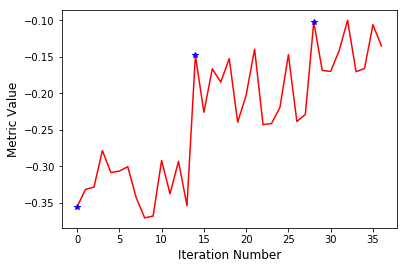

Final metric value: -0.09032489042345934
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


interactive(children=(IntSlider(value=9, description='image_z', max=18), FloatSlider(value=0.0, description='a…

In [17]:
rigid_transform = create_matrix_rigid_transform()

In [18]:
def plot_fixed_moving_transformed_images(slice_index, fixed_image, moving_image, transformed_image):
    plt.figure(figsize=(15,15))
    plt.subplot(131), plt.imshow(sitk.GetArrayFromImage(fixed_image)[slice_index] , cmap="gray"), plt.title("reference sample")
    plt.subplot(132), plt.imshow(sitk.GetArrayFromImage(moving_image)[slice_index], cmap="gray"), plt.title("Image sample")
    plt.subplot(133), plt.imshow(sitk.GetArrayFromImage(transformed_image)[slice_index], cmap="gray"), plt.title("Transformed sample")

In [19]:

def checkout_registration(idx):
    img_np = join_images_table.MRI3D[idx]
    moving_image = sitk.GetImageFromArray(img_np)
    ijk = join_images_table.ijk[idx]
    transformed_image = sitk.Resample(moving_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    interact(plot_fixed_moving_transformed_images, slice_index=(0,moving_image.GetSize()[2]-1),
             fixed_image = fixed(moving_image), moving_image=fixed(moving_image), transformed_image=fixed(transformed_image) );
    final_shape = sitk.GetArrayFromImage(transformed_image).shape
    
    ijk_list = ijk.split()
    ijk_np = np.array([float(ijk_list[0]),float(ijk_list[1]), float(ijk_list[2])])
    ijk_np_transformed = np.array(rigid_transform.TransformPoint(ijk_np))
    print("The point {} was transformed to {}".format(ijk_np,ijk_np_transformed))
    ijk_np_transformed = np.round(ijk_np_transformed)
    print("The final point was rounded to: {}".format(ijk_np_transformed))
    type(ijk_np_transformed)
    print("The final shape of the transformed image is: {}".format(final_shape))

In [20]:
checkout_registration(100)

interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [50. 69. 11.] was transformed to [48.47799767 67.7734586   9.2994847 ]
The final point was rounded to: [48. 68.  9.]
The final shape of the transformed image is: (19, 128, 84)


In [21]:
idx = 100
idx2 = 0 
img_np = join_images_table.MRI3D[idx]
img_np2 = join_images_table.MRI3D[idx2]
moving_image = sitk.GetImageFromArray(img_np)
fixed_image  = sitk.GetImageFromArray(img_np2)
ijk = join_images_table.ijk[idx]
transformed_image = sitk.Resample(moving_image , fixed_image, rigid_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(plot_fixed_moving_transformed_images, slice_index=(0,moving_image.GetSize()[2]-1),
             fixed_image = fixed(fixed_image), moving_image=fixed(moving_image), transformed_image=fixed(transformed_image) );
final_shape = sitk.GetArrayFromImage(transformed_image).shape

interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

In [22]:
random_numbers = np.random.randint(0,len(join_images_table),size=10)
for number in random_numbers:
    checkout_registration(number)

interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [34. 67. 11.] was transformed to [32.46013177 65.92597318  9.17795383]
The final point was rounded to: [32. 66.  9.]
The final shape of the transformed image is: (19, 128, 84)


interactive(children=(IntSlider(value=7, description='slice_index', max=14), Output()), _dom_classes=('widget-…

The point [165. 169.  14.] was transformed to [164.39469779 166.54775201  15.69929679]
The final point was rounded to: [164. 167.  16.]
The final shape of the transformed image is: (15, 320, 320)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [44. 61.  5.] was transformed to [42.42859031 60.01101918  3.04255216]
The final point was rounded to: [42. 60.  3.]
The final shape of the transformed image is: (19, 128, 84)


interactive(children=(IntSlider(value=7, description='slice_index', max=14), Output()), _dom_classes=('widget-…

The point [168. 151.  12.] was transformed to [167.23455558 148.58693112  13.18054302]
The final point was rounded to: [167. 149.  13.]
The final shape of the transformed image is: (15, 320, 320)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [49. 66. 11.] was transformed to [47.44999156 64.78436951  9.20701938]
The final point was rounded to: [47. 65.  9.]
The final shape of the transformed image is: (19, 128, 84)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [34. 61.  8.] was transformed to [32.41656489 60.01729595  6.00216489]
The final point was rounded to: [32. 60.  6.]
The final shape of the transformed image is: (19, 128, 84)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [53. 67. 14.] was transformed to [51.44658414 65.6575557  12.25083173]
The final point was rounded to: [51. 66. 12.]
The final shape of the transformed image is: (19, 128, 120)


interactive(children=(IntSlider(value=11, description='slice_index', max=22), Output()), _dom_classes=('widget…

The point [209. 243.   7.] was transformed to [209.11378455 240.30185933  11.05872214]
The final point was rounded to: [209. 240.  11.]
The final shape of the transformed image is: (23, 384, 384)


interactive(children=(IntSlider(value=9, description='slice_index', max=18), Output()), _dom_classes=('widget-…

The point [45. 60.  6.] was transformed to [43.41500151 58.97254474  4.01649454]
The final point was rounded to: [43. 59.  4.]
The final shape of the transformed image is: (19, 128, 84)


interactive(children=(IntSlider(value=6, description='slice_index', max=12), Output()), _dom_classes=('widget-…

The point [142. 157.   0.] was transformed to [141.34223882 155.18411287   1.26143542]
The final point was rounded to: [141. 155.   1.]
The final shape of the transformed image is: (13, 256, 256)
